In [1]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import shap


2023-12-03 17:16:04.420970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
data = pd.read_csv('../raw_data/all_data_30_horizon_with_day_of_week.csv')


In [6]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'dayofweek', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
   

In [7]:
data.dropna(inplace=True)

In [8]:
data.isna().any().any()

False

## Running preprocessor

In [9]:
processed_data = preprocess(data, raw_od_columns=['OriginCty', 'DestinationCty'], raw_od_ctry=['OriginCtry', 'DestinationCtry'] , as_ratio=True)
processed_data


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,Z_Score,MinMax_Scaled,Score_min_max,Score_Z_score,Score_Z_score_0_50
325,BCN,BCN,ES,KDU,KDU,PK,8,6267.0,True,3,...,720.0,295.0,0.290640,7543.0,1.203606,NaN,0.0,0.000000,NaN,NaN
466,BKK,BKK,TH,BOG,BOG,CO,15,17894.0,False,3,...,1481.0,938.0,0.387764,19182.0,1.071979,NaN,0.0,0.000000,NaN,NaN
743,CAI,CAI,EG,MCO,ORL,US,2,10358.0,True,3,...,960.0,2460.0,0.719298,10670.0,1.030122,NaN,0.0,0.000000,NaN,NaN
1436,HGA,HGA,SO,YOW,YOW,CA,18,11465.0,False,3,...,1092.0,370.0,0.253078,12573.0,1.096642,NaN,0.0,0.000000,NaN,NaN
1449,HKG,HKG,CN,NAP,NAP,IT,10,9168.0,True,3,...,1005.0,810.0,0.446281,11478.0,1.251963,-1.0,0.0,0.000000,-1.945910,2.454457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698816,RIX,RIX,LV,LPB,LPB,BO,27,11670.0,True,3,...,1130.0,1770.0,0.610345,13535.0,1.159811,NaN,0.0,0.000000,NaN,NaN
3699014,PVG,SHA,CN,YHZ,YHZ,CA,1,11543.0,True,3,...,1334.0,825.0,0.382121,16617.0,1.439574,1.0,1.0,1.609438,1.609438,9.160157
3699058,SJO,SJO,CR,ORY,PAR,FR,0,8922.0,True,3,...,936.0,549.0,0.369697,10646.0,1.193230,NaN,0.0,0.000000,NaN,NaN
3699194,SXM,SXM,SX,BHX,BHX,GB,21,6499.0,True,3,...,855.0,755.0,0.468944,9808.0,1.509155,NaN,0.0,0.000000,NaN,NaN


### Checking the distribution of the target (Score_Z_score_0_50)


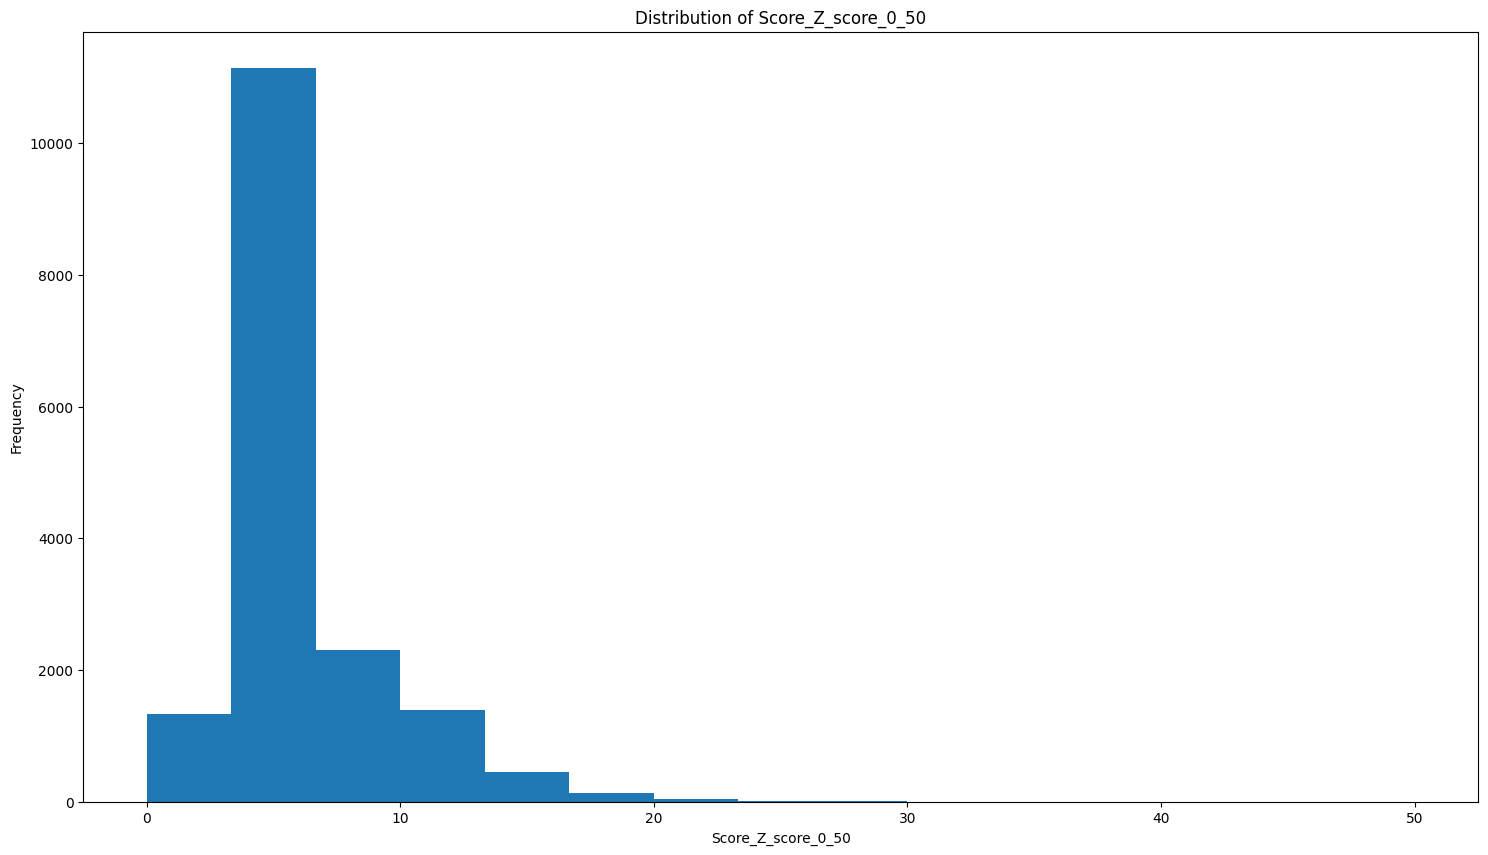

In [10]:
plt.figure(figsize=(18, 10))
plt.hist(processed_data["Score_Z_score_0_50"], bins=15)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


## Testing the binary encoder

In [11]:
# import category_encoders as ce
# # Initialize BinaryEncoder
# binary_encoder = ce.BinaryEncoder(cols=["OD"])
# # Fit and transform the data
# binary_encoded_data = binary_encoder.fit_transform(processed_data)
# # Print the result
# print("Binary Encoded data:")
# print(binary_encoded_data.columns)


## Continuing the Pre-Processing

In [12]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

model_data = processed_data[model_columns]


In [13]:
model_data.loc[:, "SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [14]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
325,6267.0,8,1,0.290640,1.203606,650.08,NaN
466,17894.0,15,0,0.387764,1.071979,760.89,NaN
743,10358.0,2,1,0.719298,1.030122,929.50,NaN
1436,11465.0,18,0,0.253078,1.096642,2269.06,NaN
1449,9168.0,10,1,0.446281,1.251963,968.69,2.454457


In [15]:
model_data.dtypes


TravelDistanceKm               float64
TravelHorizonDays                int64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
Score_Z_score_0_50             float64
dtype: object

In [16]:
corr_matrix = model_data.corr()
corr_matrix


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
TravelDistanceKm,1.000000,0.029596,-0.043405,-0.438200,-0.274824,0.447522,-0.000021
TravelHorizonDays,0.029596,1.000000,-0.095478,-0.044656,-0.049696,-0.257544,-0.041300
SelfTransfer,-0.043405,-0.095478,1.000000,0.122706,0.002294,-0.131291,-0.022569
total_layover_time_ratio,-0.438200,-0.044656,0.122706,1.000000,0.090175,-0.396310,-0.033307
extra_travel_distance_ratio,-0.274824,-0.049696,0.002294,0.090175,1.000000,-0.000639,-0.005175
PricePerPax,0.447522,-0.257544,-0.131291,-0.396310,-0.000639,1.000000,-0.007712
Score_Z_score_0_50,-0.000021,-0.041300,-0.022569,-0.033307,-0.005175,-0.007712,1.000000


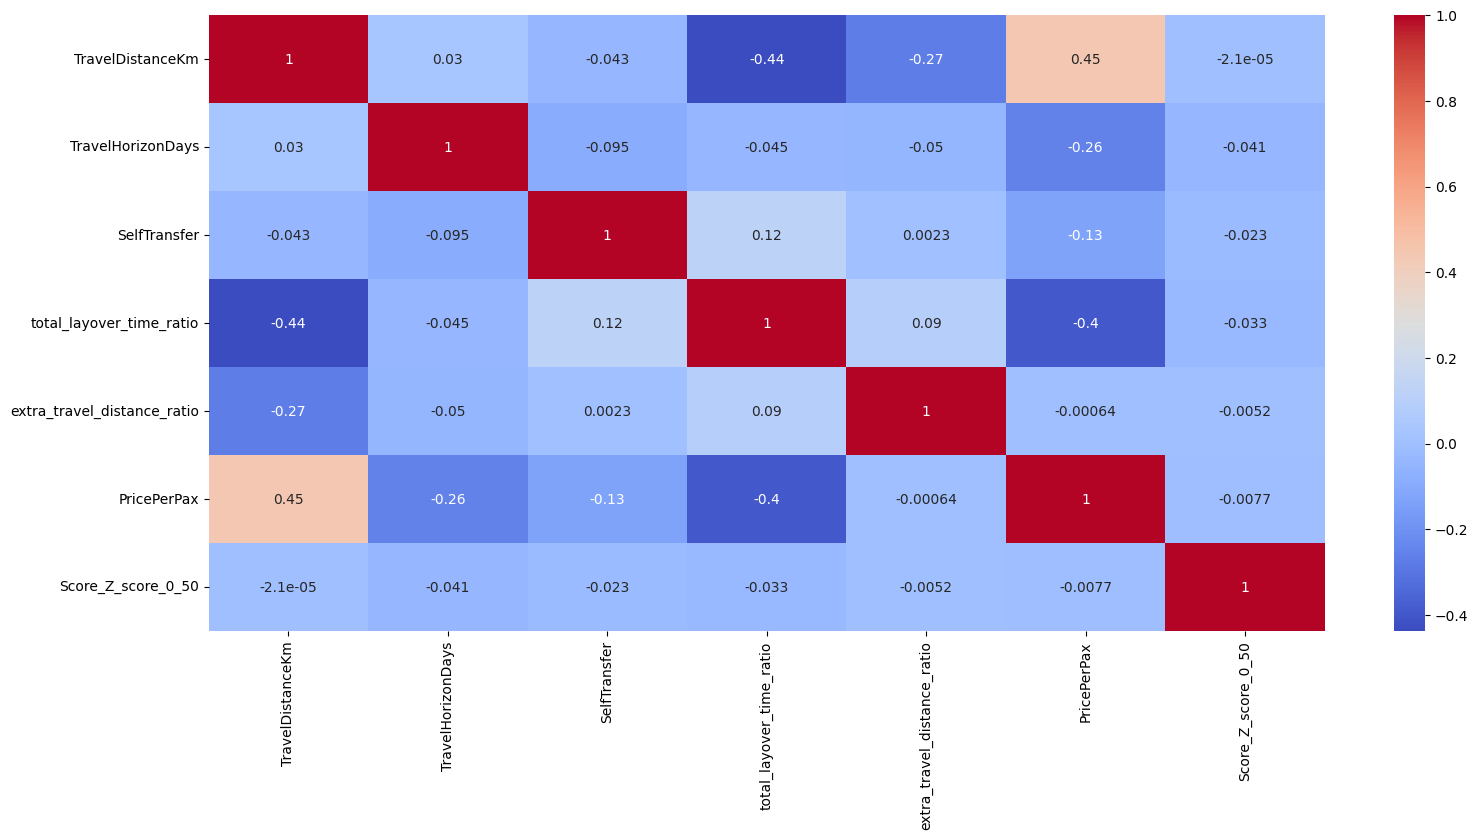

In [17]:
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


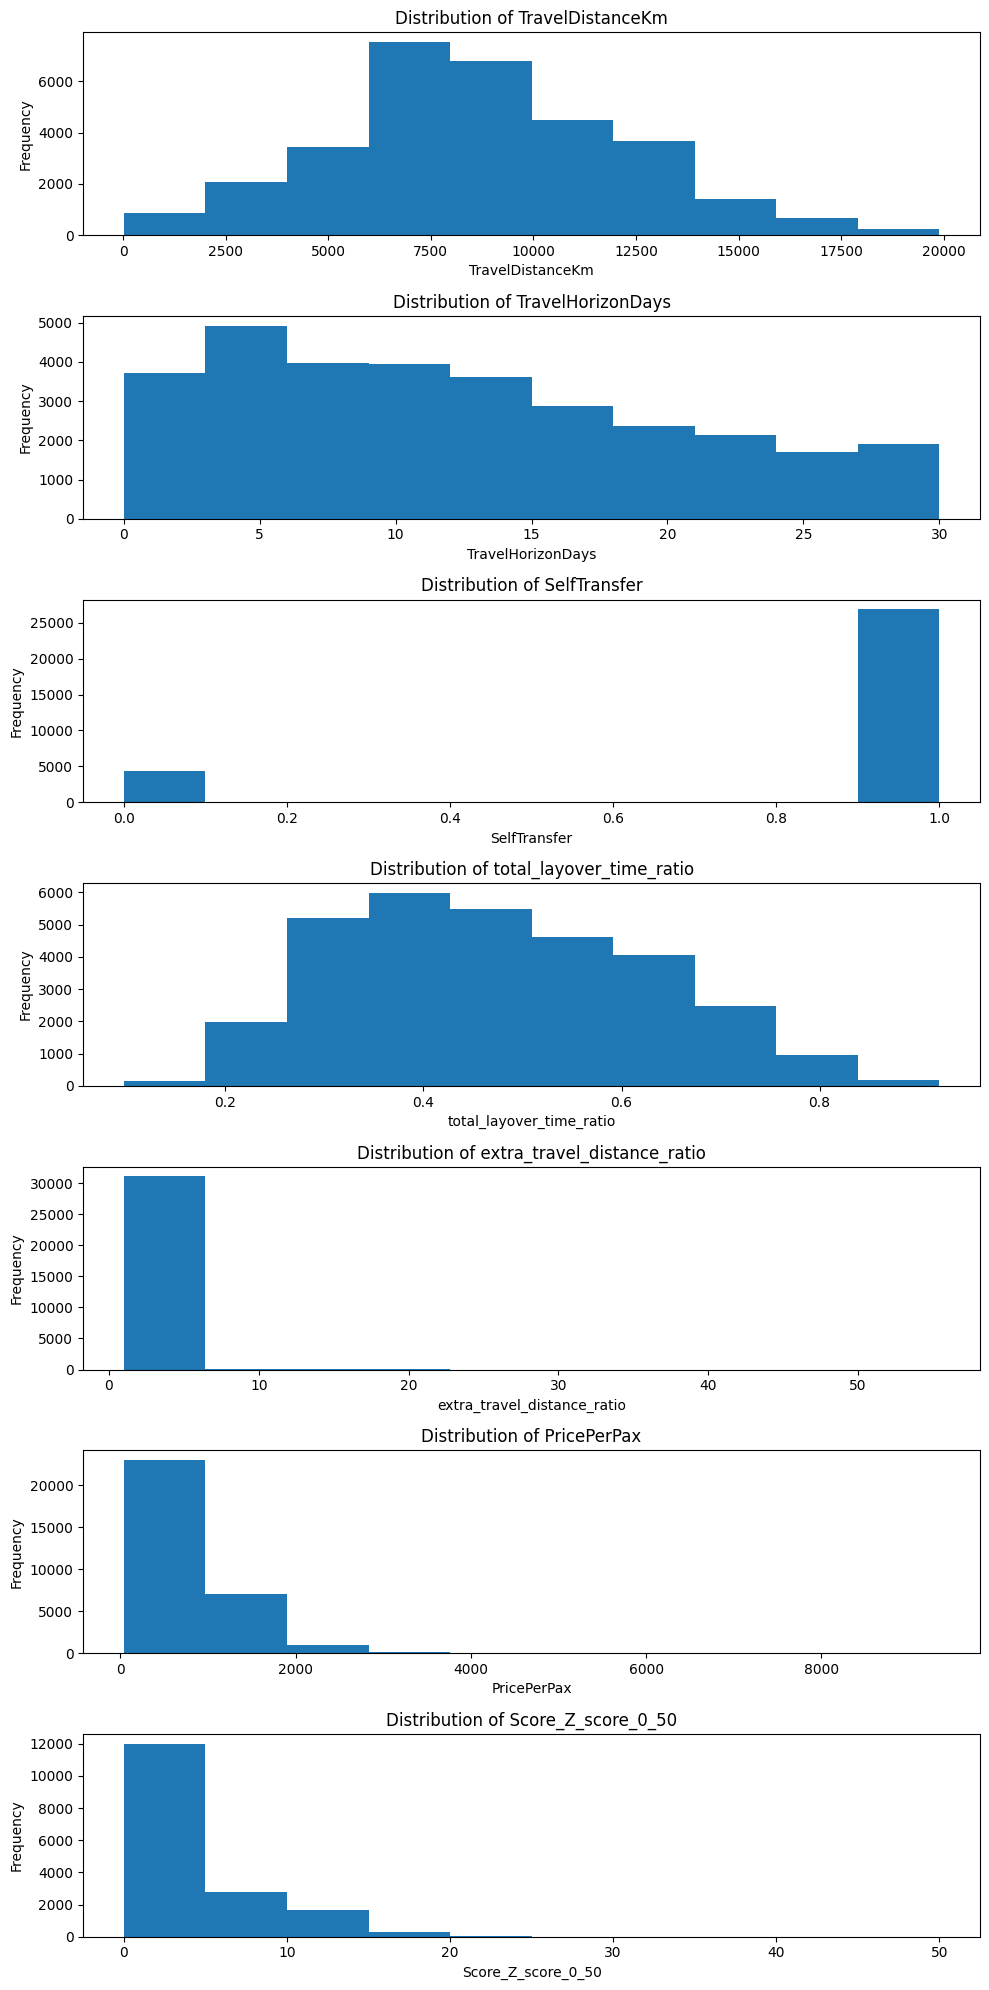

In [18]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of extra_travel_distance
- Log of PricePerPax

In [19]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax,Score_Z_score_0_50
325,6267.0,8,1,0.290640,1.203606,650.08,NaN
466,17894.0,15,0,0.387764,1.071979,760.89,NaN
743,10358.0,2,1,0.719298,1.030122,929.50,NaN
1436,11465.0,18,0,0.253078,1.096642,2269.06,NaN
1449,9168.0,10,1,0.446281,1.251963,968.69,2.454457


In [20]:
model_data.loc[:, 'extra_travel_distance_ratio'] = np.log1p(model_data['extra_travel_distance_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'PricePerPax'] = np.log1p(model_data['PricePerPax']+ 1e-9)  # 1e-9 is a small constant to offset zero values


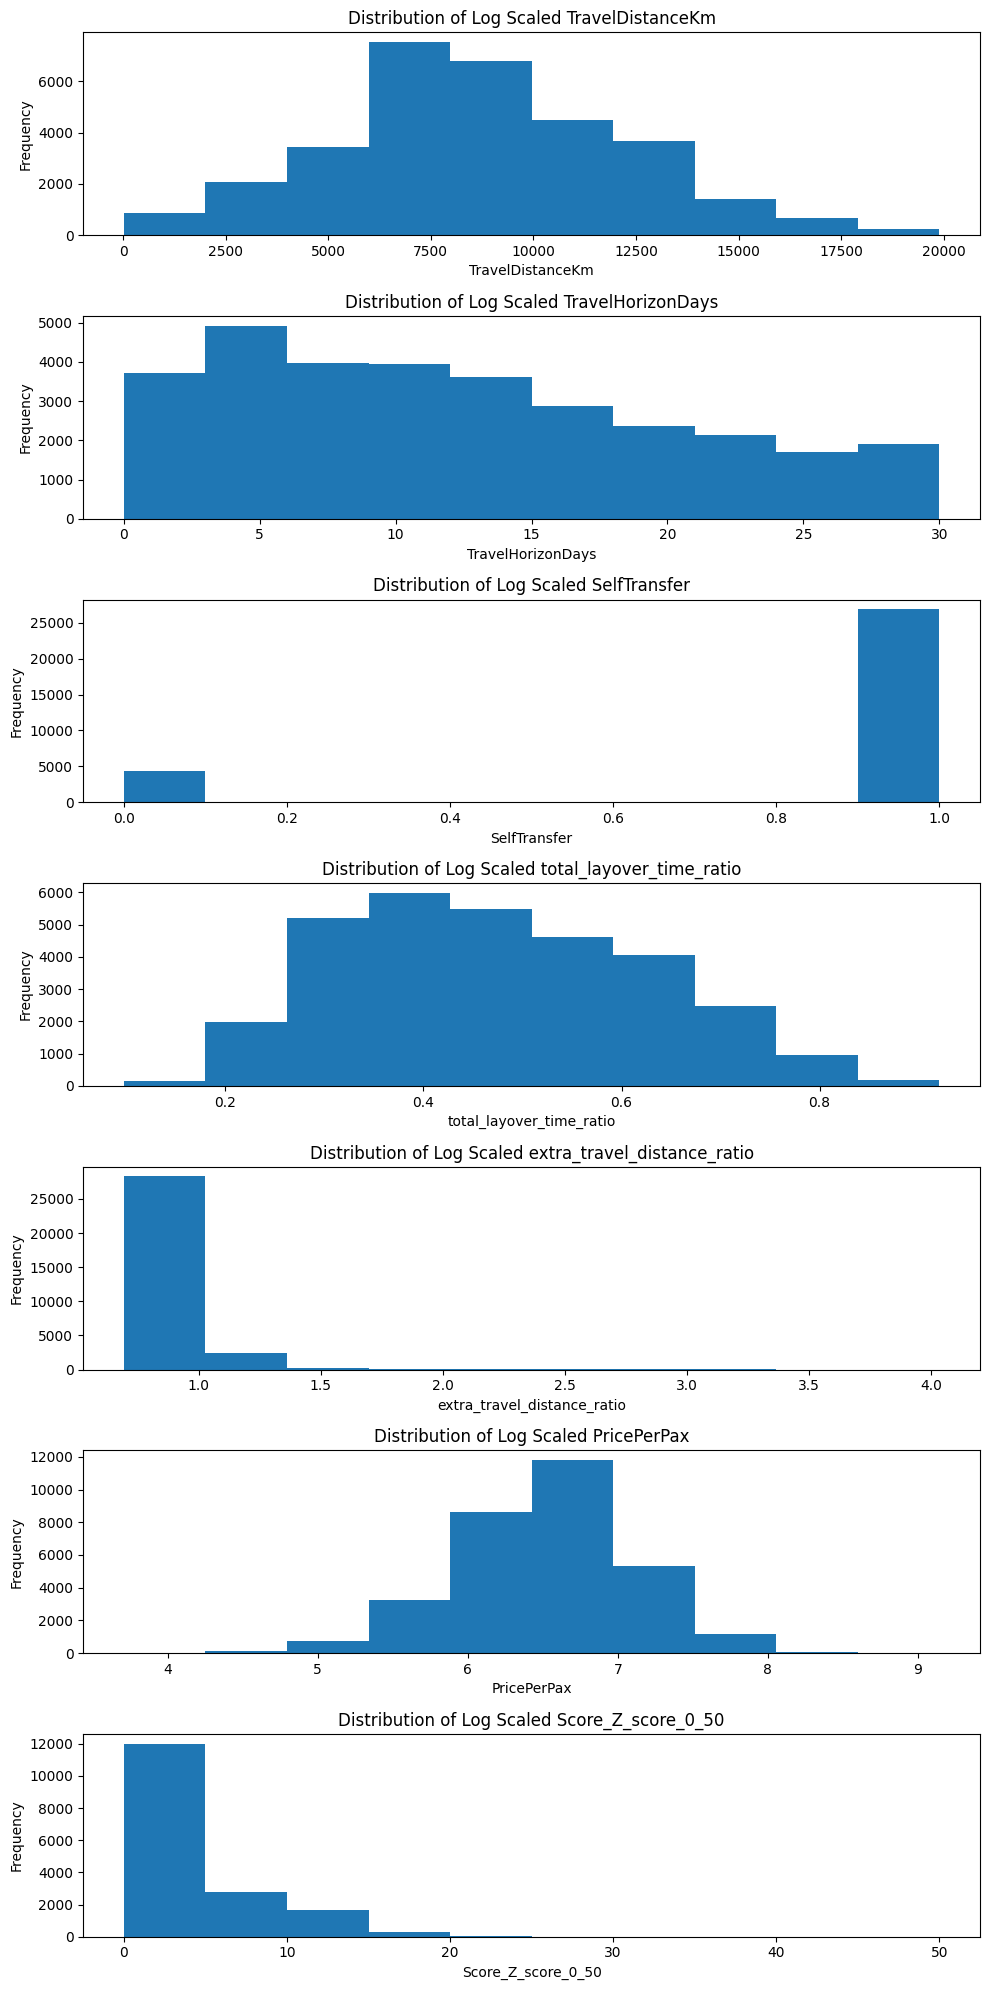

In [21]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Apply MinMax Scalar

In [22]:
model_data.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
model_data.isna().any().any()

False

In [24]:
scaler = MinMaxScaler()


In [25]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'Score_Z_score_0_50')


In [51]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [105]:
model = Sequential()
model.add(layers.Dense(64, input_dim=6, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [106]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                448       
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8833 (34.50 KB)
Trainable params: 8833 (34.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)


In [108]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [109]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10
337/337 [==============================] - 8s 14ms/step - loss: 13.3805 - mae: 2.6657 - val_loss: 10.5966 - val_mae: 2.5261
Epoch 2/10
337/337 [==============================] - 3s 8ms/step - loss: 11.4489 - mae: 2.5107 - val_loss: 10.6328 - val_mae: 2.3025
Epoch 3/10
337/337 [==============================] - 3s 9ms/step - loss: 11.3972 - mae: 2.5093 - val_loss: 10.4930 - val_mae: 2.3592
Epoch 4/10
337/337 [==============================] - 4s 11ms/step - loss: 11.3471 - mae: 2.4983 - val_loss: 10.4357 - val_mae: 2.4148
Epoch 5/10
337/337 [==============================] - 3s 9ms/step - loss: 11.3271 - mae: 2.5013 - val_loss: 10.4264 - val_mae: 2.4341
Epoch 6/10
337/337 [==============================] - 4s 10ms/step - loss: 11.3244 - mae: 2.5025 - val_loss: 10.4471 - val_mae: 2.3582
Epoch 7/10
337/337 [==============================] - 4s 11ms/step - loss: 11.3441 - mae: 2.5005 - val_loss: 10.3944 - val_mae: 2.4564
Epoch 8/10
337/337 [==============================] - 4s 1

In [116]:
#model.save('new_target_model03Dec23.h5')


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [111]:
# model = load_model('../models/my_model.h5')


In [112]:
# Evaluate the model on the test set
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


106/106 [==============================] - 1s 7ms/step - loss: 11.7042 - mae: 2.5635
Test Loss (MSE): 11.70415210723877
Test Error (MAE): 2.563481092453003


In [113]:
y_pred = model.predict(X_test)


106/106 [==============================] - 1s 5ms/step


In [114]:
y_diff = y_pred.flatten() - y_test


In [115]:
y_diff_abs = y_diff.abs()
